In [1]:
# ### ----- Imports ----- ###

# import sys
# sys.path.append('/home/sdybing/neic-mlaapde')

# from mlaapde.access import MLAAPDE_Access
# from mlaapde import UTC
import matplotlib.pyplot as plt
import numpy as np
import os.path
import os
# import shutil
# import glob
import h5py
# import tensorflow as tf

# os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'
# os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'


# mlpa = MLAAPDE_Access(data_dir = '/data/hank/mlaapde_subset/data', random_seed = 616) # 3 months
# dataset = 'subset'

# mlpa = MLAAPDE_Access(data_dir = '/data/hank/mlaapde_v1b/data', random_seed = 616)
# dataset = 'v1b'

# mlpa.data_dir

In [2]:
# mlpa.default_args

In [3]:
### ----- Parameters ----- ###

# Where to save the products
models_figs_path = '/home/sdybing/neic-mlaapde/allwaveforms/decimated/'

# MLAAPDE/data generation params
#nsamp = False # Samples of waveforms to load from MLAAPDE
#n_train_samp = 1000000
#n_valid_samp = 200000
#nsamp = n_train_samp + n_valid_samp
sr = 40 # Sampling rate
trim_sec = 60 # Trimming amount around phase pick to get from MLAAPDE
trim_pre_sec = trim_sec
trim_post_sec = trim_pre_sec
window_len = trim_pre_sec + trim_post_sec
#train_split = 0.8 # Percentage of data used in training
#valid_split = 0.2 # Percentage of data used for validation
n_channels = 3 # Instrument channels
cut_lens = [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 25, 30, 35, 40, 50, 60, 70, 80, 90, 100, 110, 120]
test_cut_lens = [7, 8]
desired_shift = 3
max_shift = desired_shift * 2 # Since the shifting method actually makes it half what this value is set to
min_snr_db = False
max_snr_db = False
log_progress_fraction = 100
valid_phases = ['P', 'Pn', 'Pg']
cast_dtype = np.float32

# Training/model params
epochs_number = 200
batch_size = int(256) # Reducing to help memory
monte_carlo_sampling = 50
drop_rate = 0.5
filters = [32, 64, 96, 128, 256] 

# Used if loading a trained model
training_samps = 100000 
training_dataset = 'v1b'
shift_status = 'shifted'
model_folder_path = '/home/sdybing/neic-mlaapde/allwaveforms/float32/'

# To make end error plots
mean_errors = []
std_errors = []

In [4]:
### ----- Where are the HDF5 files getting saved? ----- ###

# Location of HDF5 data files
# hdf5_save_dir = '/data/sdybing/allwaveforms/decimated/'
hdf5_save_dir = '/hdd/mlaapde'
if os.path.isdir(hdf5_save_dir):
    pass
else:
    os.makedirs(hdf5_save_dir)

# Pick extra labels and set keyword arguments for data parameters
return_labels = ['source_magnitude', 'source_magnitude_type', 'snr_db', 'phase_id']
kwargs = {'valid_phases':valid_phases, 'labels':return_labels, 'trim_pre_sec':trim_pre_sec, 'trim_post_sec':trim_post_sec, 'min_snr_db':min_snr_db, 'max_snr_db':max_snr_db, 'log_progress_fraction':log_progress_fraction, 'cast_dtype':cast_dtype}
#kwargs = {'valid_phases':valid_phases, 'labels':return_labels, 'trim_pre_sec':trim_pre_sec, 'trim_post_sec':trim_post_sec, 'min_snr_db':min_snr_db, 'max_snr_db':max_snr_db, 'cast_dtype':cast_dtype}

In [10]:
### ----- Load the full dataset from HDF5 files ----- ###

training_data = h5py.File(hdf5_save_dir + '/training_data.hdf5', 'r')
dataset_names = list(training_data.keys())
print(dataset_names)

train_mags = training_data['magnitude'][:]
train_phaseids = training_data['phase_id'][:]

validation_data = h5py.File(hdf5_save_dir + '/validation_data.hdf5', 'r')
valid_mags = validation_data['magnitude'][:]

testing_data = h5py.File(hdf5_save_dir + '/decimated/testing_data.hdf5', 'r')
test_mags = testing_data['magnitude'][:]

training_data.close()
validation_data.close()
testing_data.close()

['magnitude', 'magnitude_type', 'phase_id', 'snr_db', 'waves']


In [7]:
print(train_mags.shape)
print(valid_mags.shape)
print(test_mags.shape)

(2431341,)
(489268,)
(324365,)


In [8]:
idx = 741100
idx2 = 741102
# print(train_waves_t[idx])
# print(train_waves_t[idx2])
# plt.plot(train_waves_t[idx])
# plt.show()
# plt.plot(train_waves_t[idx2])
# plt.show();

# Fixing the weird nan wave

copy_mag = train_mags[0]
copy_mag2 = train_mags[1]

train_mags[idx] = copy_mag
train_mags[idx2] = copy_mag2

In [9]:
max(train_mags)

8.3

In [11]:
train_phaseids

array([b'usb000it1p_HL.ITM.HH*.--_P', b'usb000it1p_IM.MK31.BH*.--_P',
       b'usb000it1p_KZ.ABKAR.BH*.--_P', ...,
       b'us1000h4te_TA.N17K.BH*.--_Pn', b'us1000h4te_TA.O14K.BH*.--_Pn',
       b'us1000h4te_TA.O16K.BH*.--_Pn'], dtype=object)

In [15]:
i = np.where(train_mags == 4.5)[0]
len(i)

170553

In [12]:
# testing_data = h5py.File(hdf5_save_dir + '/testing_data.hdf5', 'r')

# test_mags = testing_data['magnitude'][:]

# testing_data.close()

In [13]:
# historic_path = '/data/sdybing/olderdata/arrays/'

historic_test_mags = np.load(hdf5_save_dir + '/historic_test_mags.npy')

In [14]:
print(historic_test_mags.shape)
print(test_mags.shape)

test_mags_test = np.concatenate((historic_test_mags, test_mags))
print(test_mags_test.shape)

(13449,)
(324365,)
(337814,)


In [15]:
both_test = [test_mags, historic_test_mags]

In [16]:
x = np.arange(0,9.5,0.2)

In [19]:
plt.figure(figsize = (16,8), facecolor = 'white', dpi = 300)
#plt.suptitle('Dataset EQ Magnitude Distribution', x = 0.5, y = 1.02, fontsize = 16)

plt.subplot(131)
plt.grid()
plt.hist(train_mags, bins = 50, color = '#001528', label = 'Aug. 1, 2013 - Sept. 30, 2018')
#plt.title('Training data (800,000 samples)\nAug 1, 2013 - July 31, 2017', fontsize = 14)
plt.title('Training data (2,431,341 samples)', fontsize = 14)
#plt.xlabel('Magnitude', fontsize = 14)
plt.ylabel('Log Count', fontsize = 14)
plt.yscale('log', nonpositive = 'clip')
plt.ylim(1, 10**6)
plt.tick_params(axis = 'y', labelsize = 11)
#plt.ylim(1, 2*10**5)
plt.xlim(0,9.5)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], fontsize = 11)
plt.legend(loc = 'upper left', fontsize = 11)
plt.text(x = -1.6, y = 2*10**6, s = 'a)', fontsize = 20)

plt.subplot(132)
plt.grid()
plt.hist(valid_mags, bins = 50, color = '#2DADB4', label = 'Oct. 1, 2018 - Dec. 31, 2019')
#plt.title('Validation data (200,000 samples)\nAug 1, 2017 - Apr 1, 2018', fontsize = 14)
plt.title('Validation data (489,268 samples)', fontsize = 14)
plt.xlabel('Catalog Magnitude', fontsize = 14)
# plt.ylabel('Log Count', fontsize = 14)
# plt.yticks(ticks = None, labels = None, fontsize = 11)
plt.tick_params(axis = 'y', labelleft = False)
plt.yscale('log', nonpositive = 'clip')
plt.ylim(1, 10**6)
#plt.ylim(1, 2*10**5)
plt.xlim(0,9.5)
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9], fontsize = 11)
plt.legend(loc = 'upper left', fontsize = 11)
plt.text(x = -0.1, y = 2*10**6, s = 'b)', fontsize = 20)

plt.subplot(133)
plt.grid()
plt.hist(both_test, bins = 50, color = ['#730114', '#f01f42'], label = ['MLAAPDE testing data\n(Jan. 1, 2020 - Dec. 31, 2020)', 'Extended historic data\n(Jan. 1, 2000 - Jul. 31, 2013)'], stacked = True)
#plt.hist(historic_test_mags, bins = 10, color = '#f01f42', label = 'Extended historic data\n(Jan. 1, 2000 - Jul. 31, 2013)', stacked = True)
#plt.hist(valid_mags, bins = 50, color = '#730114', label = 'MLAAPDE testing data\n(Jan. 1, 2020 - Dec. 31, 2020)', alpha = 0.8, stacked = True)
plt.title('Testing data (337,814 samples)', fontsize = 14)
#plt.xlabel('Magnitude', fontsize = 14)
#plt.ylabel('Log Count', fontsize = 14)
#plt.yticks(ticks = None, labels = None)
plt.tick_params(axis = 'y', labelleft = False)
plt.yscale('log', nonpositive = 'clip')
plt.ylim(1, 10**6)
#plt.ylim(1, 2*10**5)
plt.xlim(0,9.5)
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9], fontsize = 11)
plt.legend(loc = 'upper left', fontsize = 11)
plt.text(x = -0.1, y = 2*10**6, s = 'c)', fontsize = 20)

plt.subplots_adjust(wspace = 0)
# plt.show()
plt.savefig('/home/sdybing/mlaapde/figures/datadistrib_hist.png', format = 'PNG')
plt.close();

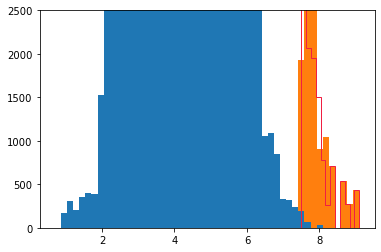

In [15]:
# fig, ax = plt.subplots(facecolor = 'white')
# ax.hist(both_test, bins = 50, stacked=True)
# ax.hist(historic_test_mags, histtype = 'step', bins = 12, color = '#f01f42', label = 'Extended historic data\n(Jan. 1, 2000 - Jul. 31, 2013)', stacked = True)
# #ax.set_yscale('log',nonpositive = 'clip')
# plt.ylim(0,2500)
# plt.show()

In [ ]:
### ----- Imports ----- ###

import sys
sys.path.append('/home/sdybing/neic-mlaapde')

from mlaapde.access import MLAAPDE_Access
from mlaapde import UTC
import matplotlib.pyplot as plt
import numpy as np
import os.path
import os
import shutil
import glob
import h5py
import tensorflow as tf

In [5]:
### ----- Load the full dataset from HDF5 files ----- ###

training_data = h5py.File(hdf5_save_dir + '/training_data.hdf5', 'r')
dataset_names = list(training_data.keys())
print(dataset_names)

train_mags = training_data['magnitude'][:]

validation_data = h5py.File(hdf5_save_dir + '/validation_data.hdf5', 'r')

valid_mags = validation_data['magnitude'][:]

training_data.close()
validation_data.close()

['magnitude', 'magnitude_type', 'phase_id', 'snr_db', 'waves']


In [6]:
print(train_mags.shape)
print(valid_mags.shape)

(2431341,)
(489268,)


In [7]:
idx = 741100
idx2 = 741102
# print(train_waves_t[idx])
# print(train_waves_t[idx2])
# plt.plot(train_waves_t[idx])
# plt.show()
# plt.plot(train_waves_t[idx2])
# plt.show();

# Fixing the weird nan wave

copy_mag = train_mags[0]
copy_mag2 = train_mags[1]

train_mags[idx] = copy_mag
train_mags[idx2] = copy_mag2

In [9]:
# testing_data = h5py.File(hdf5_save_dir + '/testing_data.hdf5', 'r')

# test_mags = testing_data['magnitude'][:]

# testing_data.close()

In [10]:
historic_path = '/data/sdybing/olderdata/arrays/'

historic_test_mags = np.load(historic_path + 'historic_test_mags.npy')

In [11]:
print(historic_test_mags.shape)
print(valid_mags.shape)

test_mags_test = np.concatenate((historic_test_mags, valid_mags))
print(test_mags_test.shape)

(13449,)
(489268,)
(502717,)


In [12]:
both_test = [valid_mags, historic_test_mags]

In [13]:
x = np.arange(0,9.5,0.2)

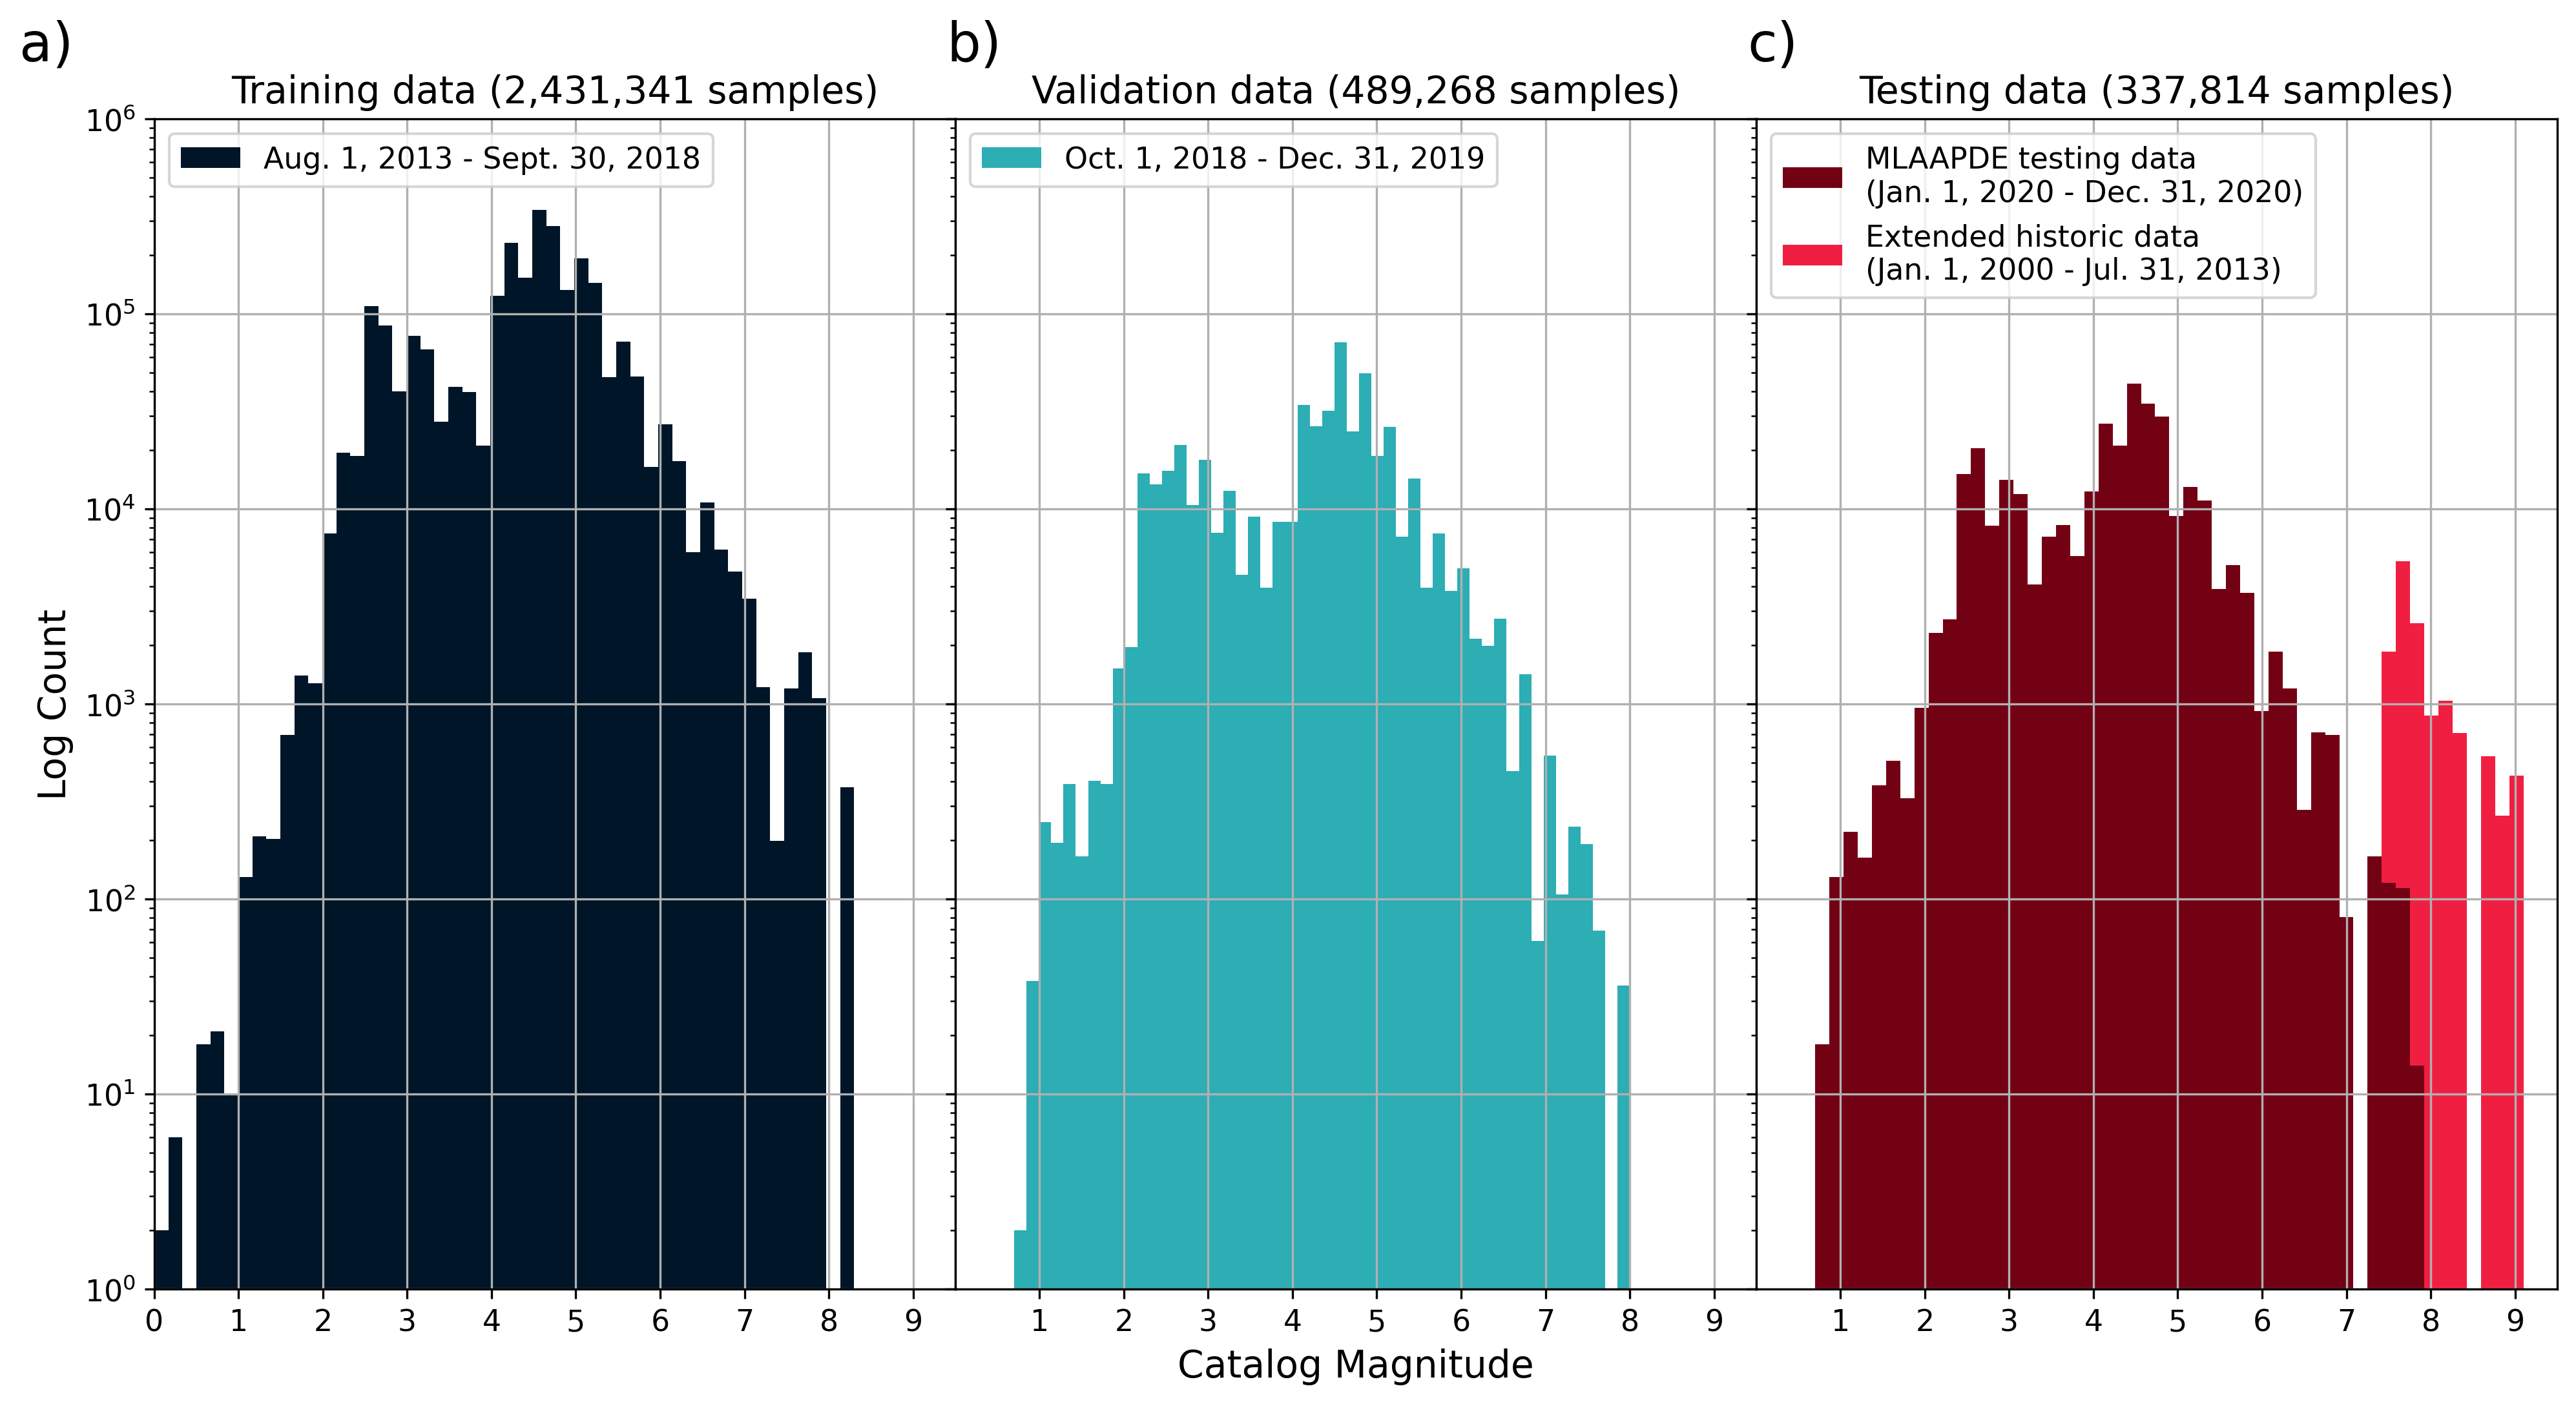

In [21]:
plt.figure(figsize = (16,8), facecolor = 'white', dpi = 300)
#plt.suptitle('Dataset EQ Magnitude Distribution', x = 0.5, y = 1.02, fontsize = 16)

plt.subplot(131)
plt.grid()
plt.hist(train_mags, bins = 50, color = '#001528', label = 'Aug. 1, 2013 - Sept. 30, 2018')
#plt.title('Training data (800,000 samples)\nAug 1, 2013 - July 31, 2017', fontsize = 14)
plt.title('Training data (2,431,341 samples)', fontsize = 14)
#plt.xlabel('Magnitude', fontsize = 14)
plt.ylabel('Log Count', fontsize = 14)
plt.yscale('log', nonpositive = 'clip')
plt.ylim(1, 10**6)
plt.tick_params(axis = 'y', labelsize = 11)
#plt.ylim(1, 2*10**5)
plt.xlim(0,9.5)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], fontsize = 11)
plt.legend(loc = 'upper left', fontsize = 11)
plt.text(x = -1.6, y = 2*10**6, s = 'a)', fontsize = 20)

plt.subplot(132)
plt.grid()
plt.hist(valid_mags, bins = 50, color = '#2DADB4', label = 'Oct. 1, 2018 - Dec. 31, 2019')
#plt.title('Validation data (200,000 samples)\nAug 1, 2017 - Apr 1, 2018', fontsize = 14)
plt.title('Validation data (489,268 samples)', fontsize = 14)
plt.xlabel('Catalog Magnitude', fontsize = 14)
# plt.ylabel('Log Count', fontsize = 14)
# plt.yticks(ticks = None, labels = None, fontsize = 11)
plt.tick_params(axis = 'y', labelleft = False)
plt.yscale('log', nonpositive = 'clip')
plt.ylim(1, 10**6)
#plt.ylim(1, 2*10**5)
plt.xlim(0,9.5)
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9], fontsize = 11)
plt.legend(loc = 'upper left', fontsize = 11)
plt.text(x = -0.1, y = 2*10**6, s = 'b)', fontsize = 20)

plt.subplot(133)
plt.grid()
plt.hist(both_test, bins = 50, color = ['#730114', '#f01f42'], label = ['MLAAPDE testing data\n(Jan. 1, 2020 - Dec. 31, 2020)', 'Extended historic data\n(Jan. 1, 2000 - Jul. 31, 2013)'], stacked = True)
#plt.hist(historic_test_mags, bins = 10, color = '#f01f42', label = 'Extended historic data\n(Jan. 1, 2000 - Jul. 31, 2013)', stacked = True)
#plt.hist(valid_mags, bins = 50, color = '#730114', label = 'MLAAPDE testing data\n(Jan. 1, 2020 - Dec. 31, 2020)', alpha = 0.8, stacked = True)
plt.title('Testing data (337,814 samples)', fontsize = 14)
#plt.xlabel('Magnitude', fontsize = 14)
#plt.ylabel('Log Count', fontsize = 14)
#plt.yticks(ticks = None, labels = None)
plt.tick_params(axis = 'y', labelleft = False)
plt.yscale('log', nonpositive = 'clip')
plt.ylim(1, 10**6)
#plt.ylim(1, 2*10**5)
plt.xlim(0,9.5)
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9], fontsize = 11)
plt.legend(loc = 'upper left', fontsize = 11)
plt.text(x = -0.1, y = 2*10**6, s = 'c)', fontsize = 20)

plt.subplots_adjust(wspace = 0)
plt.show()
# plt.savefig('/home/sdybing/neic-mlaapde/paperfigs/datadistrib_hist.png', format = 'PNG')
# plt.close();